In [50]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import sanitize_ligand_name, parse_plip_output

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

In [3]:
pg_modelling_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
data_folder = pg_modelling_folder / 'ZoocinA_O54308'
assert data_folder.is_dir()

# Zoocin A TRD domain

Ligands:
- Bridge crosslink from S. equi: two Alanine (main positive control)
- Bridge crosslink from S. equi: three Alanine (main negative control)
- Bridge crosslink from S. aureus: pentaglycine (negative control)
- Direct crosslink from E. coli (negative control)
- Any odd lipid in the same molecular weight ballpark (negative control)

In [4]:
E_coli_libary = pg_modelling_folder / 'PG_library' / 'Escherichia_coli' / 'E_coli_cell_wall_library.xlsx'
S_equi_libary = pg_modelling_folder / 'PG_library' / 'Streptococcus_equi' / 'S_equi_cell_wall_library.xlsx'
S_aureus_libary = pg_modelling_folder / 'PG_library' / 'Staphylococcus_aureus' / 'S_aureus_cell_wall_library.xlsx'

pg_library = pd.concat(
    [
        pd.read_excel(
            E_coli_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            E_coli_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=1,
        ),
    ],
    ignore_index=True,
)
pg_library['ligand_id'] = pg_library['Name'].apply(sanitize_ligand_name)
pg_library = pg_library.drop_duplicates('ligand_id')
pg_library = pg_library.set_index('ligand_id')
print(f'N = {len(pg_library):,}')

N = 2,553


In [5]:
subset_ids = [
    'KA-3-NH2-AA-3br-4-qKA',
    'KA-3-NH2-AAA-3br-4-qKA',
    'KA-3-NH2-GGGGG-3br-4-qKA',
    'mA-3s-4-emA',
]
pg_library_subset = pg_library.loc[subset_ids].rename(columns={
    'SMILES': 'smiles',
    'Monoisotopic Mass': 'mass',
})[['smiles', 'mass']]
print(f'N = {len(pg_library_subset):,}')
pg_library_subset

N = 4


,smiles,mass
ligand_id,,
KA-3-NH2-AA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,686.40752
KA-3-NH2-AAA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,757.44464
KA-3-NH2-GGGGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CN...,829.44061
mA-3s-4-emA,CC(NC(=O)C(N)CCCC(NC(=O)C(C)NC(=O)C(CCCC(N)C(=...,633.29697


In [6]:
# Pick larg-ish lipid from E. coli: (3S)-citryl-CoA
lipid_maps = pd.read_csv(pg_modelling_folder / 'PG_library' / 'lipid_maps' / 'lipids.csv')
lipid_df = lipid_maps[lipid_maps['NAME'] == '(3S)-citryl-CoA'].copy()
lipid_df['ligand_id'] = lipid_df['NAME'].apply(lambda n: f'lipid-{sanitize_ligand_name(n)}')
lipid_df = lipid_df.set_index('ligand_id').rename(columns={
    'SMILES': 'smiles',
    'EXACT_MASS': 'mass',
})[['smiles', 'mass']]

ligands_df = pd.concat([pg_library_subset, lipid_df])
ligands_df.to_csv(data_folder / 'ligands.csv')
print(f'N = {len(ligands_df):,}')
ligands_df

N = 5


,smiles,mass
ligand_id,,
KA-3-NH2-AA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,686.407520
KA-3-NH2-AAA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,757.444640
KA-3-NH2-GGGGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CN...,829.440610
mA-3s-4-emA,CC(NC(=O)C(N)CCCC(NC(=O)C(C)NC(=O)C(CCCC(N)C(=...,633.296970
lipid-3S-citryl-CoA,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,941.131659


## Results

In [40]:
binding_sites = {
    ('Asn', 32),
    ('Gln', 84),
    ('Trp', 94),
    ('Asn', 96),
}  # Source: https://doi.org/10.1016/j.bbrc.2013.09.087

def parse_results(path):
    df = pd.read_csv(path, index_col='ligand_name')
    df['aev_plig_pK_norm'] = df.apply(
        lambda row: row['aev_plig_pK'] / (ligands_df.loc[row.name, 'mass'] / 1000),
        axis=1,
    )
    df['binding_site'] = df['structure_file'].apply(interact_with_binding_site)
    return df


def interact_with_binding_site(structure_path_str : str) -> bool:
    p = data_folder / 'modelling' / re.sub(r'^.*?modelling/', '', structure_path_str.replace('.cif', '_plip')) / 'report.xml'
    if not p.is_file():
        return False
    
    plip_df = parse_plip_output(p)
    for residue_name, residue_number in plip_df[['residue_name', 'residue_number']].values:
        key = (residue_name.title(), residue_number)
        if key in binding_sites:
            return True
    return False


In [41]:
def sort_and_drop_duplicates(df):
    out_df = df.reset_index().sort_values(
        [
            'protein_name', 'ligand_name', 'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False,
    ).drop_duplicates(
        ['protein_name', 'ligand_name']
    ).set_index('ligand_name')

    return out_df.sort_values(
        [
            'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False
    )

In [42]:
colors = {
    'KA-3-NH2-AA-3br-4-qKA': '#3cb44b',
    'KA-3-NH2-AAA-3br-4-qKA': '#e6194B',
    'KA-3-NH2-GGGGG-3br-4-qKA': '#4363d8',
    'mA-3s-4-emA': '#9A6324',
    'lipid-3S-citryl-CoA': '#aaaaaa',
}
def plot_confidence_vs_pk(df, marker_size=15):
    if len(df) == 0:
        return None

    ligands = sorted(set(df.index))

    df_bs = df[df['binding_site']]
    df_no_bs = df[~df['binding_site']]

    ax = None
    if len(df_bs) > 0:
        ax = df_bs.plot.scatter(
            x='confidence', 
            y='aev_plig_pK_norm',
            c=[colors[l] for l in df_bs.index],
            alpha=[
                1.0 if row['posebusters_score'] == 20 else 0.2
                for _, row in df_bs.iterrows()
            ],
            marker='o',
            s=marker_size,
        );

    if len(df_no_bs) > 0:
        ax = df_no_bs.plot.scatter(
            x='confidence', 
            y='aev_plig_pK_norm',
            c=[colors[l] for l in df_no_bs.index],
            alpha=[
                1.0 if row['posebusters_score'] == 20 else 0.2
                for _, row in df_no_bs.iterrows()
            ],
            marker='x',
            s=marker_size,
            ax=ax,
        );
    
    ax.set_ylabel('Predicted pKd per kDa');

    legend_handles = [
        mlines.Line2D([], [], color=colors[l], marker='o', linestyle='None', markersize=6, label=l)
        for l in ligands
    ]
    legend1 = ax.legend(
        handles=legend_handles, 
        title='Ligands', 
        bbox_to_anchor=(1, 1.1), 
        frameon=False,
    );

    legend_handles2 = [
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', markersize=6, label='Interact with binding site'),
        mlines.Line2D([], [], color=palette[0], marker='x', linestyle='None', markersize=6, label='Do not interact with binding site'),
    ]
    legend2 = ax.legend(
        handles=legend_handles2, 
        title='Binding site', 
        bbox_to_anchor=(1, 0.5), 
        frameon=False,
    );

    legend_handles3 = [
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', alpha=1.0, markersize=6, label='Perfect PoseBusters score (20 of 20)'),
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', alpha=0.3, markersize=6, label='PoseBusters score < 20'),
    ]
    ax.legend(
        handles=legend_handles3, 
        title='PoseBusters', 
        bbox_to_anchor=(1, 0.2), 
        frameon=False,
    );

    ax.add_artist(legend1)
    ax.add_artist(legend2)

    plt.subplots_adjust(right=0.75)

    return ax

In [147]:
def plot_confidence(df_input, marker_size=15):
    if len(df_input) == 0:
        return None
    
    df = df_input.reset_index().sort_values(['ligand_name'], ascending=False)

    ax = df.plot.scatter(
        x='confidence', 
        y='ligand_name',
        c=[
            '#3cb44b' if row['binding_site'] else '#e6194B'
            for _, row in df.iterrows()
        ],
        marker='o',
        alpha=[
            1.0 if row['posebusters_score'] == 20 else 0.2
            for _, row in df.iterrows()
        ],
        s=marker_size,
        figsize=(5, 3),
    );

    ax.set_xlabel('Confidence');
    ax.set_ylabel('Ligand');
    return ax

### AF3

In [43]:
af3_results_all = parse_results(data_folder / 'modelling' / 'af3' / 'scores.csv')
af3_results = sort_and_drop_duplicates(af3_results_all)
af3_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
mA-3s-4-emA,ZoocinA_O54308_TRD_179_283,463,2,/home/rs1521/PG/ZoocinA_O54308/modelling/af3/r...,0.85,0.74,0.762,20,3.9,NaN,5.36,8.463644,True
KA-3-NH2-AA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,62,3,/home/rs1521/PG/ZoocinA_O54308/modelling/af3/r...,0.83,0.67,0.702,20,3.2,NaN,5.23,7.619380,True
lipid-3S-citryl-CoA,ZoocinA_O54308_TRD_179_283,975,4,/home/rs1521/PG/ZoocinA_O54308/modelling/af3/r...,0.80,0.62,0.656,20,37.4,NaN,6.13,6.513435,True
KA-3-NH2-GGGGG-3br-4-qKA,ZoocinA_O54308_TRD_179_283,757,0,/home/rs1521/PG/ZoocinA_O54308/modelling/af3/r...,0.79,0.59,0.630,20,3.5,NaN,5.14,6.196948,False
KA-3-NH2-AAA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,81,0,/home/rs1521/PG/ZoocinA_O54308/modelling/af3/r...,0.79,0.57,0.614,20,3.8,NaN,5.20,6.865188,True


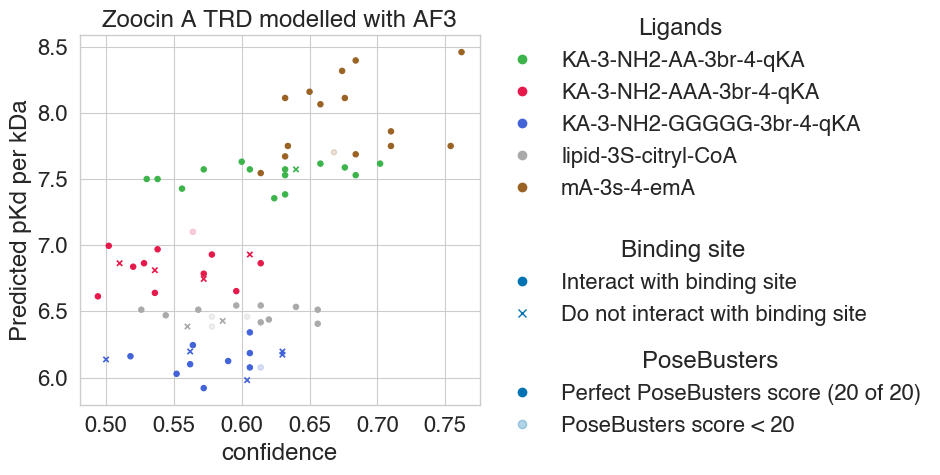

In [113]:
ax = plot_confidence_vs_pk(af3_results_all);
ax.set_title('Zoocin A TRD modelled with AF3');

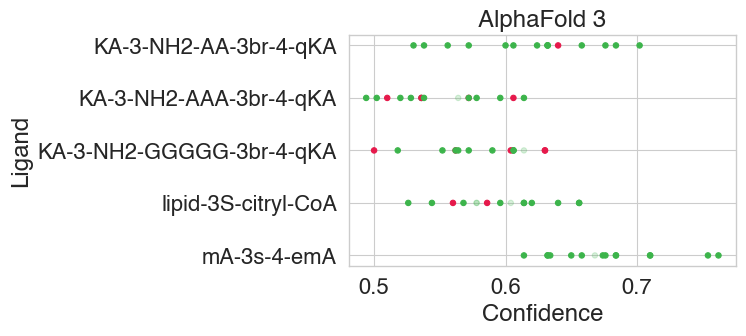

In [148]:
ax = plot_confidence(af3_results_all);
ax.set_title('AlphaFold 3');

### Boltz

In [45]:
boltz_results_all = parse_results(data_folder / 'modelling' / 'boltz' / 'scores.csv')
boltz_results = sort_and_drop_duplicates(boltz_results_all)
boltz_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
lipid-3S-citryl-CoA,ZoocinA_O54308_TRD_179_283,281,0,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.826220,0.600119,0.645,20.0,5.3,NaN,6.11,6.492184,False
mA-3s-4-emA,ZoocinA_O54308_TRD_179_283,444,0,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.822567,0.479138,0.548,20.0,6.8,NaN,5.14,8.116255,True
KA-3-NH2-AAA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,281,2,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.726039,0.262941,0.356,20.0,5.1,NaN,5.18,6.838784,True
KA-3-NH2-AA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,281,0,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.737875,0.259453,0.355,20.0,8.8,NaN,4.99,7.269734,True
KA-3-NH2-GGGGG-3br-4-qKA,ZoocinA_O54308_TRD_179_283,281,3,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.690697,0.181245,0.283,20.0,9.2,NaN,4.81,5.799089,True


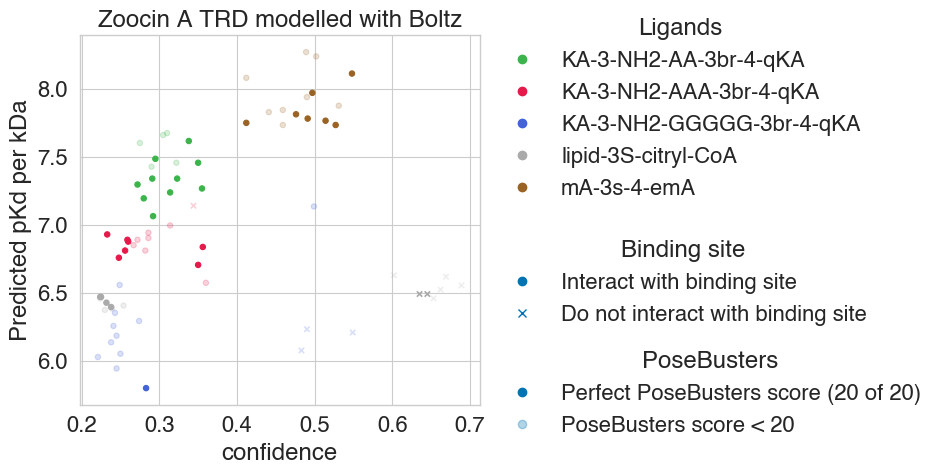

In [46]:
ax = plot_confidence_vs_pk(boltz_results_all);
ax.set_title('Zoocin A TRD modelled with Boltz');

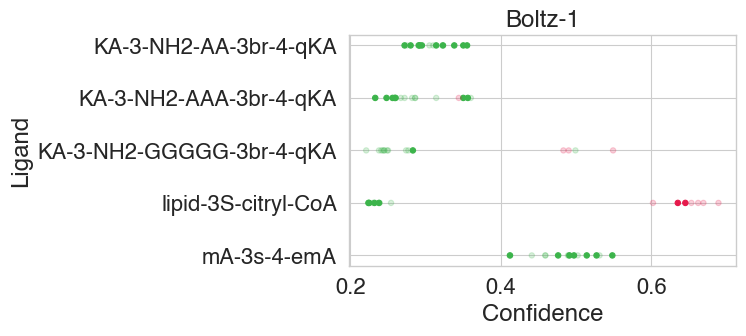

In [149]:
ax = plot_confidence(boltz_results_all);
ax.set_title('Boltz-1');

### Chai

In [47]:
chai_results_all = parse_results(data_folder / 'modelling' / 'chai' / 'scores.csv')
chai_results = sort_and_drop_duplicates(chai_results_all)
chai_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
KA-3-NH2-AA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,843,4,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.848575,0.395823,0.486,20,6.3,NaN,5.05,7.357146,True
KA-3-NH2-AAA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,960,2,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.824518,0.387263,0.475,20,18.1,NaN,5.38,7.102829,True
mA-3s-4-emA,ZoocinA_O54308_TRD_179_283,843,3,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.802331,0.259741,0.368,20,3.1,NaN,5.03,7.942561,True
lipid-3S-citryl-CoA,ZoocinA_O54308_TRD_179_283,843,1,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.725763,0.240413,0.337,20,5.3,NaN,6.13,6.513435,True
KA-3-NH2-GGGGG-3br-4-qKA,ZoocinA_O54308_TRD_179_283,960,2,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.726963,0.188917,0.297,20,3.8,NaN,4.93,5.943765,True


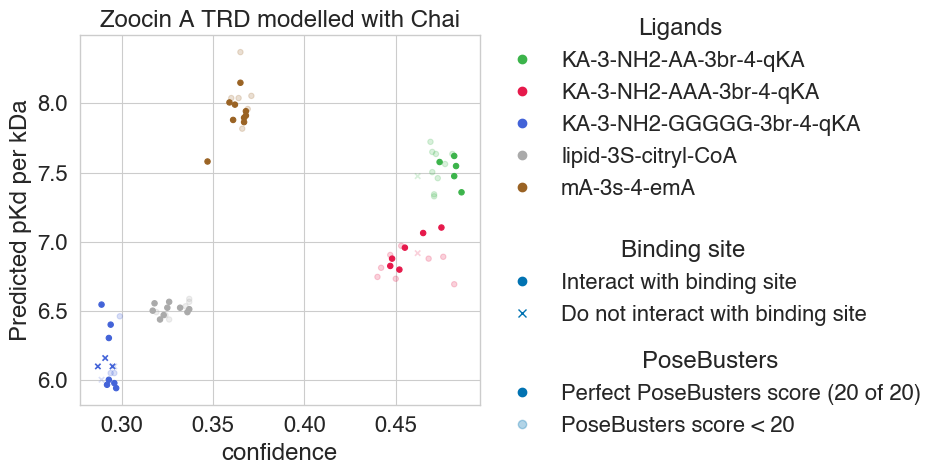

In [49]:
ax = plot_confidence_vs_pk(chai_results_all);
ax.set_title('Zoocin A TRD modelled with Chai');

plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/parts/zooA_chai.pdf', dpi=300, bbox_inches='tight')

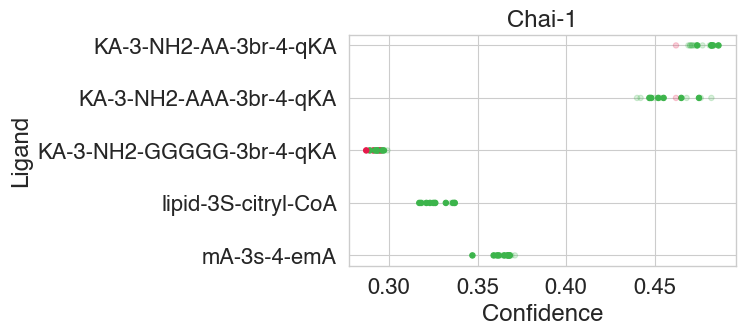

In [150]:
ax = plot_confidence(chai_results_all);
ax.set_title('Chai-1');

### Protenix

In [75]:
protenix_results_all = parse_results(data_folder / 'modelling' / 'protenix' / 'scores.csv')
protenix_results = sort_and_drop_duplicates(protenix_results_all)
protenix_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
mA-3s-4-emA,ZoocinA_O54308_TRD_179_283,240,0,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.973629,0.951507,0.956,20,4.2,NaN,4.92,7.768867,False
lipid-3S-citryl-CoA,ZoocinA_O54308_TRD_179_283,240,3,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.962481,0.924017,0.932,20,4.3,NaN,6.08,6.460308,True
KA-3-NH2-AA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,558,1,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.966277,0.924035,0.932,20,11.9,NaN,5.11,7.444557,True
KA-3-NH2-AAA-3br-4-qKA,ZoocinA_O54308_TRD_179_283,240,0,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.964397,0.923890,0.932,20,5.6,NaN,5.00,6.601142,False
KA-3-NH2-GGGGG-3br-4-qKA,ZoocinA_O54308_TRD_179_283,558,1,/gpfs/home/rs1521/PG/ZoocinA_O54308/modelling/...,0.961123,0.919346,0.928,20,5.1,NaN,5.03,6.064328,True


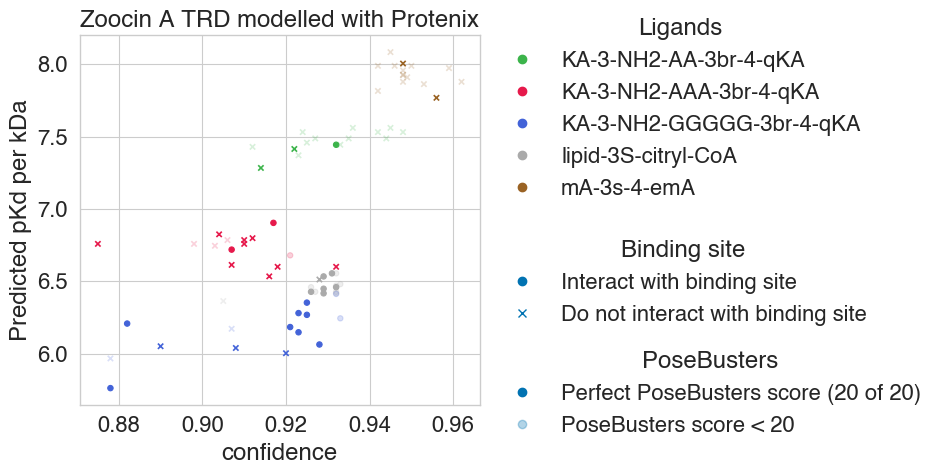

In [76]:
ax = plot_confidence_vs_pk(protenix_results_all);
ax.set_title('Zoocin A TRD modelled with Protenix');

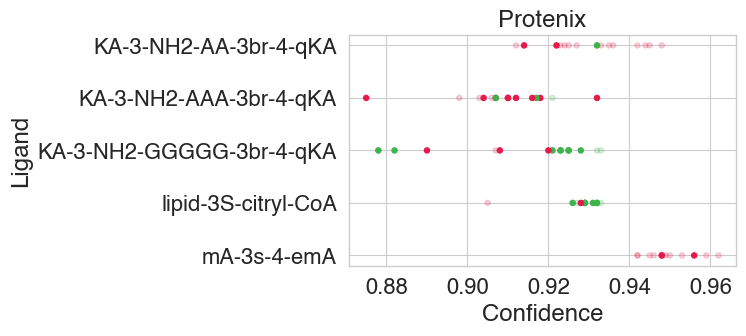

In [151]:
ax = plot_confidence(protenix_results_all);
ax.set_title('Protenix');